In [9]:
import os
import io
import sys
import math
import joblib
import datetime
from tqdm import tqdm
from copy import deepcopy

## Data Structures and illustrations ##
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## sklearn ##
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

In [11]:
## Import data
df_train = pd.read_csv('df_train_v2.csv')
df_val = pd.read_csv('df_val_v2.csv')
df_test = pd.read_csv('df_test_v2.csv')

Examples:
    Total: 19522
    Positive: 4692 (24.03% of total)
    Negative: 14830 (75.97% of total)



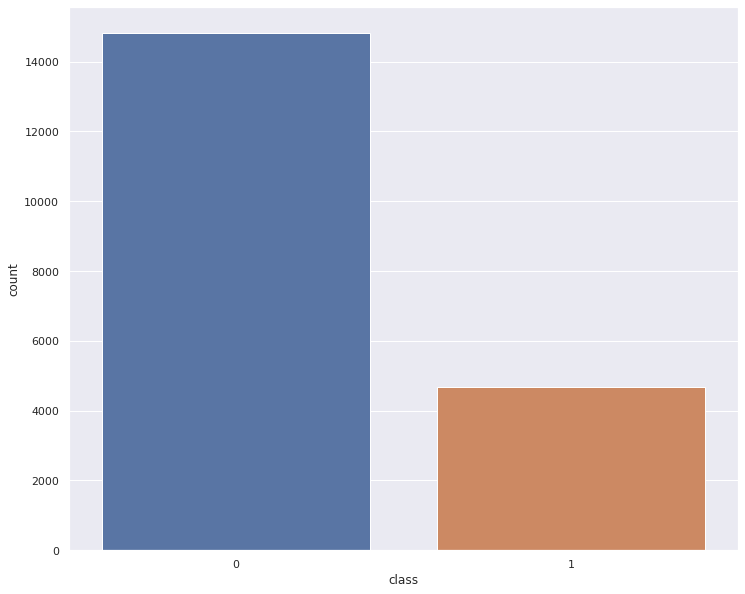

In [12]:
## Class imbalance
sb.set(style="darkgrid")
ax = sb.countplot(x="class", data=df_train)

## Deal with calss imbalance for training by weighting loss to class or upsampling

neg, pos = np.bincount(df_train['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total,))

In [13]:
## Change Column type to categorical
for col in df_train.select_dtypes(['object']).columns:
    df_train[col] = df_train[col].astype('category')
    
for col in df_val.select_dtypes(['object']).columns:
    df_val[col] = df_val[col].astype('category')
    
for col in df_test.select_dtypes(['object']).columns:
    df_test[col] = df_test[col].astype('category')

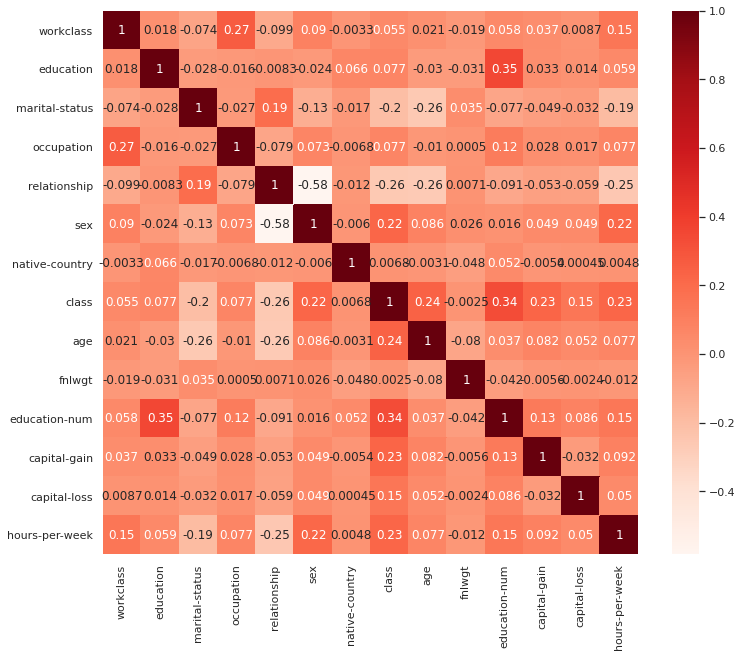

class    1.0
Name: class, dtype: float64


In [14]:
# Correlation Table
correlation_df = deepcopy(df_train)
cat_columns = correlation_df.select_dtypes(['category']).columns
correlation_df[cat_columns] = df_train[cat_columns].apply(lambda x: x.cat.codes)

cor = correlation_df.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Correlation with output variable
cor_target = abs(cor['class'])

# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.5]
print(relevant_features)

In [15]:
## Categorical Transformations
cat_columns = df_train.select_dtypes(['category']).columns
df_merge = pd.concat([df_train, df_val], axis=0)
thres = len(df_train)
df_merge = pd.get_dummies(df_merge, cat_columns)
df_train = df_merge.iloc[0:thres]
df_val = df_merge.iloc[thres:]

In [16]:
x_train, y_train, x_test, y_test = df_train.drop('class', axis=1), df_train['class'], df_val.drop('class', axis=1), df_val['class']

In [17]:
# Feature Selection via Statistical Tests
from sklearn.feature_selection import SelectKBest, f_classif

test = SelectKBest(score_func=f_classif, k=8)
fit = test.fit(x_train, y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(8, 'Score'))

                                 Specs        Score
33  marital-status_ Married-civ-spouse  4907.732966
53               relationship_ Husband  3884.062740
2                        education-num  2481.670537
35       marital-status_ Never-married  2214.009201
0                                  age  1215.323851
3                         capital-gain  1072.676487
5                       hours-per-week  1050.448166
56             relationship_ Own-child  1047.654021


In [19]:
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
pima2_acc = []
pima2_f1 = []

depth=5

## KNN

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)

## Logistic Regression

clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_pred = clf.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)

## Decision Tree

clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)

## Random Forest Classifier

clf = RandomForestClassifier(max_depth=depth, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)

## Gradient Boosting

clf = GradientBoostingClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)

# please use the following function to calculate f1 and acc
# f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
# acc = round(accuracy_score(y_test, y_pred) * 100, 2)

# Your code should fill in pima1_acc, pima2_acc, pima1_f1, and pima2_f1, each of which should be length-5 
# lists containing the accuracy (or f1) of each of the 5 algorithms on pima1 (or pima2). The code below 
# will then automatically produce the appropriate results tables. 

# --- End of your code ---

accuracy_record = pd.DataFrame({'Model': model_names, 'acc': pima2_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'f1': pima2_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

/ldap_home/leonard.lee/miniconda/envs/5228/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          acc  acc_mean
Model                  
KNN    83.020    83.020
LR     84.960    84.960
DT     84.000    84.000
RF     83.670    83.670
GBM    86.740    86.740
avg    84.478    84.478


           f1  F1_mean
Model                 
KNN    82.710   82.710
LR     84.400   84.400
DT     82.510   82.510
RF     81.290   81.290
GBM    86.220   86.220
avg    83.426   83.426


In [ ]:
# from espressomaker import Espresso
from hyperopt import hp, fmin, tpe
from sklearn.model_selection import KFold, cross_val_score

parameters = {'min_samples_leaf': hp.quniform('min_samples_leaf', 10, 50, 2),
              'learning_rate': hp.uniform('learning_rate', 0.001, 0.8),
#                   'criterion': ['friedman_mse', 'mse'],
#                   'loss': ['deviance', 'exponential'],
              'max_depth': hp.quniform('max_depth', 2, 12, 2),
              'subsample': hp.uniform('subsample', 0.5, 1.0)
             }

def lgb_objective(params):
    params = {'min_samples_leaf': int(params['min_samples_leaf']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'subsample': params['subsample']}

    gbm_init = GradientBoostingClassifier(n_estimators=100, loss='exponential', criterion='mse', **params)
    best_score = cross_val_score(gbm_init, x_train.values, y_train, scoring='f1', cv=10, n_jobs=-1).mean()
    loss = 1 - best_score
    return loss

gbm_best = fmin(fn=lgb_objective,space=parameters, max_evals=500, rstate=np.random.RandomState(21), algo=tpe.suggest)
print(gbm_best)

In [20]:
## This should be the result of the best params
# gbm_best = {'learning_rate': 0.25811008823486786, 'max_depth': 4.0, 'min_samples_leaf': 14.0, 'subsample': 0.992898593688096}

87.13 86.73
Legitimate Transactions Detected (True Negatives):  3497
Legitimate Transactions Incorrectly Detected (False Positives):  220
Fraudulent Transactions Missed (False Negatives):  408
Fraudulent Transactions Detected (True Positives):  756
Total Fraudulent Transactions:  1164


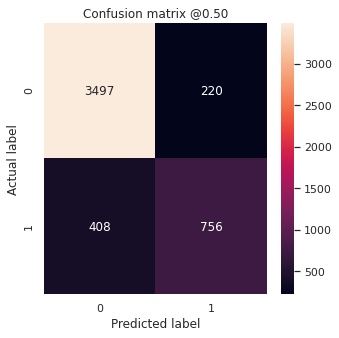

In [21]:
gbm_best['min_samples_leaf'] = 14
gbm_init = GradientBoostingClassifier(n_estimators=100, loss='exponential', criterion='mse', **gbm_best, random_state=21)
gbm_init.fit(x_train, y_train)
y_pred = gbm_init.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
print(acc, f1)

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sb.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    
plot_cm(y_test, y_pred)

In [22]:
# Voting Classifier (without Keras)
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

# gbm_init = GradientBoostingClassifier(criterion='mse', learning_rate=0.1, loss='exponential', max_depth=6, warm_start=True)
gbm_best['min_samples_leaf'] = 14
gbm_init = GradientBoostingClassifier(n_estimators=100, loss='exponential', criterion='mse', **gbm_best, random_state=21)
xgbc = XGBClassifier(objective='binary:logistic',silent=True, nthread=1, gamma= 0.01, learning_rate= 0.1, max_depth= 6, min_child_weight=1)

estimators_in = [
    ('gbm', gbm_init),
    ('xgbc', xgbc),
]

eclf = VotingClassifier(estimators=estimators_in,
                       voting='hard',
                       n_jobs=16,
                       )
eclf.fit(x_train, y_train)
y_pred = eclf.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
print(acc, f1)

gbm_init.fit(x_train, y_train)
xgbc.fit(x_train, y_train)

y_pred = xgbc.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
print(acc, f1)

y_pred = gbm_init.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
print(acc, f1)


eclf2 = EnsembleVoteClassifier(clfs=[gbm_init, xgbc], voting='soft', fit_base_estimators=False)
eclf2.fit(x_test, y_test)
y_pred = eclf2.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
print(acc, f1)

86.87 86.22
86.85 86.32
87.13 86.73
86.83 86.37


/ldap_home/leonard.lee/miniconda/envs/5228/lib/python3.7/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


In [25]:
best_model_to_output = eclf2

In [26]:
# Feature Importance Extraction
print(best_model_to_output.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(best_model_to_output.feature_importances_, index=x_train.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

AttributeError: 'EnsembleVoteClassifier' object has no attribute 'feature_importances_'

In [27]:
train_categories = {}
for col in df_train.select_dtypes(['category']).columns:
    df_train[col] = df_train[col].unique().to_list()
    
test_categories = {}
for col in df_test.select_dtypes(['category']).columns:
    test_categories[col] = df_test[col].unique().to_list()

In [28]:
category_mapping = {}
for col in train_categories:
    same = set(train_categories[col]).intersection(set(test_categories[col]))
    different = set(test_categories[col]).difference(set(train_categories[col]))
    missing = set(train_categories[col]).difference(set(test_categories[col]))
    
    category_mapping[col] = {}
    for s in same:
        category_mapping[col][s] = s
    for d in different:
        category_mapping[col][d] = ' ?'
    category_mapping[col]['missing'] = missing

In [29]:
mapped_test_data = df_test.replace(category_mapping)

In [30]:
for col in mapped_test_data.select_dtypes(['object']).columns:
    mapped_test_data[col] = mapped_test_data[col].astype('category')

In [31]:
cat_cols = mapped_test_data.select_dtypes(['category']).columns

In [32]:
mapped_test_data = pd.get_dummies(mapped_test_data, cat_cols)

In [33]:
_, rescaled_test_data = x_train.align(mapped_test_data, join='left', axis=1)

In [37]:
rescaled_test_data[rescaled_test_data.isna()] = 0

In [38]:
output_pred = best_model_to_output.predict(rescaled_test_data)
output_df = pd.DataFrame({'id': [i+1 for i in range(len(output_pred))], 'prediction': output_pred})
output_df['prediction'].sum()

4756

In [36]:
output_df.to_csv('predictions_eclf2_2.csv', index=False)